# INTRODUCTION

Parkinson's Disease (PD) is a complex neurodegenerative disorder with a multifactorial etiology, encompassing both genetic and environmental factors. Despite advances in understanding PD's pathophysiology, the genetic underpinnings remain elusive, with multiple genes and variants contributing to disease risk and progression. 

The advent of **Whole Exome Sequencing (WES)** has enabled researchers to probe the genetic landscape of PD with unprecedented detail, offering new avenues to uncover the genetic contributors to the disease.

This notebook delves into an analysis of WES data from PD patients and healthy controls, with a primary focus on selecting genomic variants to apply dimensionality reduction techniques. Dimensionality reduction is crucial in genetic studies for several reasons: it helps in uncovering the underlying structure of high-dimensional data, reduces the computational burden for downstream analyses, and can highlight genetic signatures that differentiate disease states. By focusing on this aspect, the analysis aims to bridge the gap between raw genetic data and actionable genetic insights that could inform further PD research.

## Topics Covered in This Notebook

- **Data loading**: Use of the python library scikit-allel to load vcf files into the memory.

- **Variant Selection**: Criteria for selecting variants from the WES data for further analysis, followed by annotation to provide context about their biological significance.
  
- **Application of Dimensionality Reduction Techniques**: Detailed exploration of various dimensionality reduction methods applied to the selected genomic variants, aimed at identifying patterns and structures within the data that may differentiate PD patients from healthy controls.
  
- **Interpretation of Dimensionality Reduction Results**: Analysis of the reduced-dimensional space to understand the genetic landscape of PD, including identification of clusters, outliers, and potential genetic markers of the disease.
  
- **Future Directions:** Summarization of the methods discussed in the notebook, and suggestions for secondary analysis 

# 1 - DATA AND LIBRARY LOADING 

## 1.1 - LIBARIES

In [1]:
from google.cloud import storage
import pandas as pd
import os
import numpy as np
import sgkit as sg
import allel
from sklearn import decomposition
import matplotlib.pyplot as plt

## 1.2 - Load GCP service account

In [2]:
# Path to your service account key file
service_account_key_path = 'formal-landing-281116-e68536ab9d30.json'

# Set the GOOGLE_APPLICATION_CREDENTIALS environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = service_account_key_path

## 1.3 - Declare functions to interact with Storage

In [3]:
def download_blob_to_file(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket to a local file."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"Downloaded {source_blob_name} to {destination_file_name}")

## 1.4 - Download data from existing bucket.

The data is written on the memory. Therefore the following download will increase significatly the memory usage.

In [4]:
# Example usage

bucket_name = 'exome-seq-data'
source_blob_name = 'ppmi.feb.1.2015.vcf'  # Path to your file within the bucket
destination_file_name = '/home/jovyan/wes-data/ppmi.feb.1.2015.vcf' 

download_blob_to_file(bucket_name, source_blob_name, destination_file_name)

Downloaded ppmi.feb.1.2015.vcf to /home/jovyan/wes-data/ppmi.feb.1.2015.vcf


## 1.5 - Read vcf file

The code snippet provided is leveraging the **scikit-allel library** to process genetic variation data from VCF (Variant Call Format) data. A crucial aspect of this code involves the use of the fields argument in the allel.read_vcf() function. By specifying the fields argument, the allel.read_vcf() function can selectively load only the relevant data into memory, which can significantly enhance performance and reduce memory usage, especially when dealing with large VCF files.

In the given code, the fields list includes several specific fields:

- **samples**: To identify the samples included in the analysis.

- **calldata/GT**: To load the genotype information, which is crucial for understanding the genetic makeup of each sample regarding the variants.
  
- **variants/QUAL**: To assess the quality score of each variant, which helps in filtering variants based on their confidence level.
  
- **variants/DP**: To understand the depth of coverage for each variant, providing insights into the amount of sequencing data supporting the variant.
  
- **variants/MQ**: To check the mapping quality of the reads supporting each variant, ensuring the reliability of the variant mapping.
  
- **variants/is_snp**: To identify whether a variant is a SNP, a common type of genetic variation.

In [5]:
# By providing the field "*", we will import all information in the VCF file
# If we don't specify the fields arguments, we will import the following information:
# 'calldata/GT', 'samples', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID',
# 'variants/POS', 'variants/QUAL', 'variants/REF'.

fields = ['samples','calldata/GT','variants/QUAL', 'variants/DP', 'variants/MQ', 'variants/MQ', 'variants/is_snp']

wes_set = allel.read_vcf(destination_file_name, fields = fields)
print("Exome sequencing data successfully loaded ...")

Exome sequencing data successfully loaded ...


## 1.6 - Remove file from the memory

Step needed it to release memory usage

In [6]:
os.remove(destination_file_name)
print(f"The file {destination_file_name} has been deleted from the folder wes-data") 

The file /home/jovyan/wes-data/ppmi.feb.1.2015.vcf has been deleted from the folder wes-data


## 1.7 - Number of sample variants

In [ ]:
number_of_samples = len(wes_set['samples'])
number_of_variants = allel.GenotypeArray(wes_set['calldata/GT']).shape[0]

print(f"The number of samples in the current Exome sequencing experiment is: {number_of_samples}")
print(f"The number of variants detected in the current Exome sequencing dataset is: {number_of_variants}")

# 2 - Variant Selection

## 2.1 - Select variants based on quality

Many variant calling pipelines, such as GATK, FreeBayes, and Samtools, incorporate initial quality filtering to ensure that only variants with a certain level of confidence are reported. Despite the initial filtering, further refinement based on quality metrics is often recommended for several reasons. To this end, I aimed to to furhter filter the varaint data based on quality metrics.

Before applying any filtering. The code snippet below is designed to visualize the distribution of three quality metrics: 

- **variant quality (QUAL)**
- **coverage depth(DP)**
- **mapping quality(MQ)** 

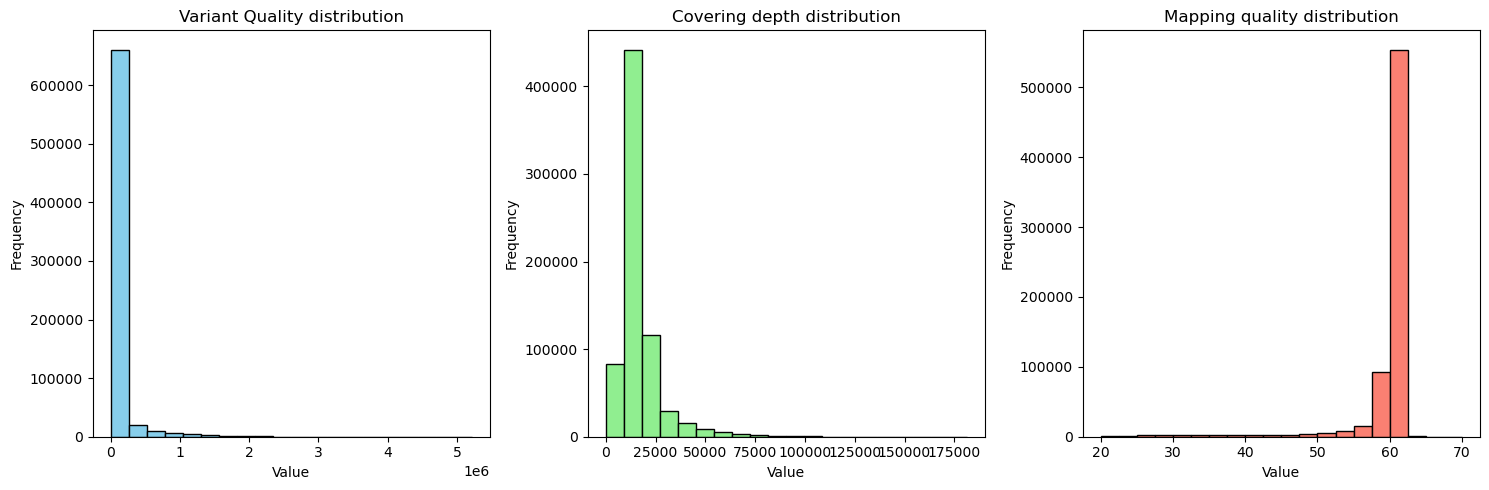

In [7]:
# Create a figure of histograms to assess the distribution
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plotting each dataset in a separate subplot
axs[0].hist(wes_set['variants/QUAL'], bins=20, color='skyblue', edgecolor='black')
axs[0].set_title('Variant Quality distribution')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(wes_set['variants/DP'], bins=20, color='lightgreen', edgecolor='black')
axs[1].set_title('Covering depth distribution')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

axs[2].hist(wes_set['variants/MQ'], bins=20, color='salmon', edgecolor='black')
axs[2].set_title('Mapping quality distribution')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

# Adjust layout to make room for the plot titles and labels
plt.tight_layout()

# Display the plot
plt.show()

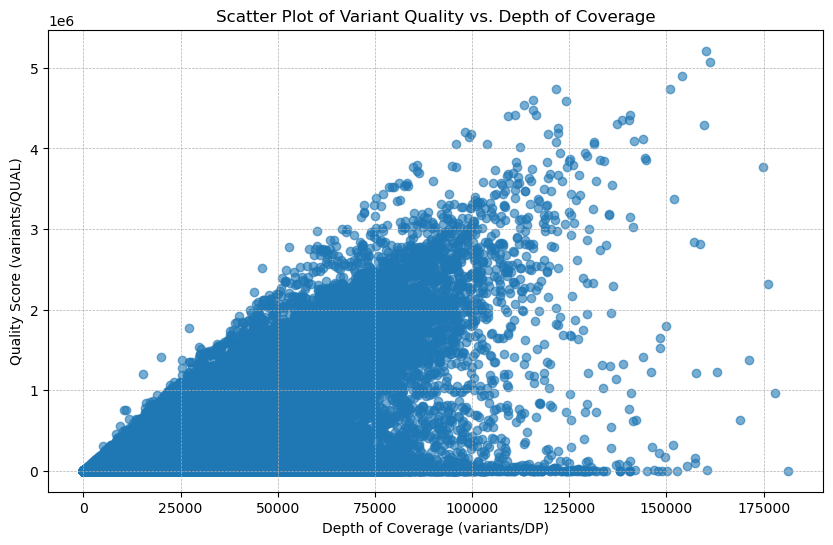

In [8]:
# Generate an scatter plot to visualize the relationship between QUAL and DP
plt.figure(figsize=(10, 6))
plt.scatter(wes_set['variants/DP'], wes_set['variants/QUAL'], alpha=0.6)
plt.title('Scatter Plot of Variant Quality vs. Depth of Coverage')
plt.xlabel('Depth of Coverage (variants/DP)')
plt.ylabel('Quality Score (variants/QUAL)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### Justification for the Applied Filters

- **Mapping Quality Filter (MQ < 50):**
  
Rationale: A low mapping quality indicates that the reads supporting a variant do not align well to the reference genome. This can suggest potential alignment errors, which may lead to false-positive variant calls.

- **Depth of Coverage Filter (DP <= 100):**
  
Rationale: Depth of coverage is indicative of how many sequencing reads support a given variant. A low depth may result from sequencing errors or low-quality data, which can result in uncertain variant calls. In our case. it seems the DP has been already filtered because all the variants in the dataset have a minimum of a DP of 30 which is already acceptable. I have set a threshold to flag variants with a DP of 100 or less helps to ensure that each retained variant call is supported by a sufficient amount of sequencing data, thus enhancing the reliability of these calls.

- **Combination Filter (DP > 75K and QUAL <= 100K):**

Rationale: We observed that some variants exhibiting extremely high depth of coverage (such as over 75,000) did not resulted in very high quality scores (over 100,000) as the bulk of the data. Therefore, I decided to exclude these variant calls.

In [9]:
# Create a DataFrame
df = pd.DataFrame({
    'DP': wes_set['variants/DP'],
    'QUAL': wes_set['variants/QUAL'],
    'MQ': wes_set['variants/MQ']
})

# Apply the filters and create a 'Flag' column
df['Flag'] = 0  # Initialize with 0 (no flag)

# Condition 1: Flag if MQ < 50
df.loc[(df['MQ'] <= 50) | (df['DP'] <= 100), 'Flag'] = 1

# Condition 2: Flag if DP > 75K and QUAL <= 100K
df.loc[(df['DP'] >= 75000) & (df['QUAL'] <= 100000), 'Flag'] = 1

# Create boolean array

quality_samples = df['Flag'] == 0

print(df['Flag'].value_counts())

# Filter genotype data 

g = allel.GenotypeChunkedArray(wes_set['calldata/GT'])
g = g[quality_samples]

print(f"The genotypes calls have been succesfully filtered")

Flag
0    675649
1     31401
Name: count, dtype: int64
The genotypes calls have been succesfully filtered


## 2.2 - Exclude uninformative variants

### 2.2.1 - Singletons

**What is a Singleton?**
A singleton in genetic terms refers to a variant that appears only once within the population or dataset being studied. It means that the alternate allele is observed in only one copy among all the chromosomes sampled. Singletons can arise due to very rare mutations that have occurred in the germ line of a single individual (or very recently in evolutionary terms), and they have not yet been propagated through the population.

**Why Remove Singletons?**
Removing singletons from genetic analyses can be important for several reasons:

- Noise Reduction: Singletons might represent sequencing errors, especially if they do not replicate across different studies or sequencing platforms. Their removal can reduce noise.
- Statistical Power: Singletons provide very little information for statistical analysis because their low frequency makes it hard to determine their significance or effect size reliably.
- Population Genetics: In population genetics studies, singletons may not be very informative because they do not contribute to the allelic diversity in the same way that more common variants do.

### 2.2.2 - Multiallelic SNPs

**Why Remove Multiallelic SNPs?**

Multiallelic SNPs are loci where more than two alleles (variants) are observed. While biallelic SNPs have two alleles (typically one reference and one alternate), multiallelic SNPs may have three or more alleles due to multiple mutations at the same locus. Based on my research, it seems to be very beneficial to remove multiallelic SNPs for secondary analysis.

### 2.2.3 - Exclude variants with only reference alleles

Variants with only reference alleles across the samples sequenceds are clearly uninformative and should be removed.

In [10]:
# To perform these operation, We first will count the frequency of alleles for each variant

ac = g.count_alleles()[:] # The operator '[:]' allows to return an arrayy

In [15]:
ac

<AlleleCountsArray shape=(675649, 7) dtype=int32>
1146  140    0    0    0    0    0
1287    1    0    0    0    0    0
1256   34    0    0    0    0    0
...
788   2   0   0   0   0   0
846   2   0   0   0   0   0
764  78   0   0   0   0   0

In [13]:
# Assuming 'ac' is your AlleleCountsArray from 'scikit-allel', with each row representing a variant
# and columns representing allele counts (the first column for the reference allele, subsequent columns for alternate alleles).

# Filter 1: Exclude multiallelic SNPs by ensuring we only have two alleles (reference and one alternate)
is_biallelic = ac.max_allele() == 1

# Filter 2: Exclude singletons by checking if the count of the alternate allele is greater than 1
# Note: This considers the dataset already being filtered to biallelic, hence looking only at the first alternate allele
no_singletons = ac[:, 1] > 1

# Filter 3: Exclude variants with only reference alleles by ensuring there's at least one alternate allele count
has_alternate_alleles = ac[:, 1:].sum(axis=1) > 1

# Combine all filters
flt = is_biallelic & no_singletons & has_alternate_alleles

In [14]:
gf = g.compress(flt, axis=0) # This is the filtering step

## 2.3 - High frequency of alternate alleles rates

In [16]:
# Re-count alleles
ac = gf.count_alleles()[:]
ac

<AlleleCountsArray shape=(329151, 2) dtype=int32>
1146  140
1256   34
1256   34
...
788   2
846   2
764  78

In [17]:
# Correct calculation for mutation rate as a percentage
mutation_rates = (ac[:, 1] / (ac[:, 0] + ac[:, 1])) * 100

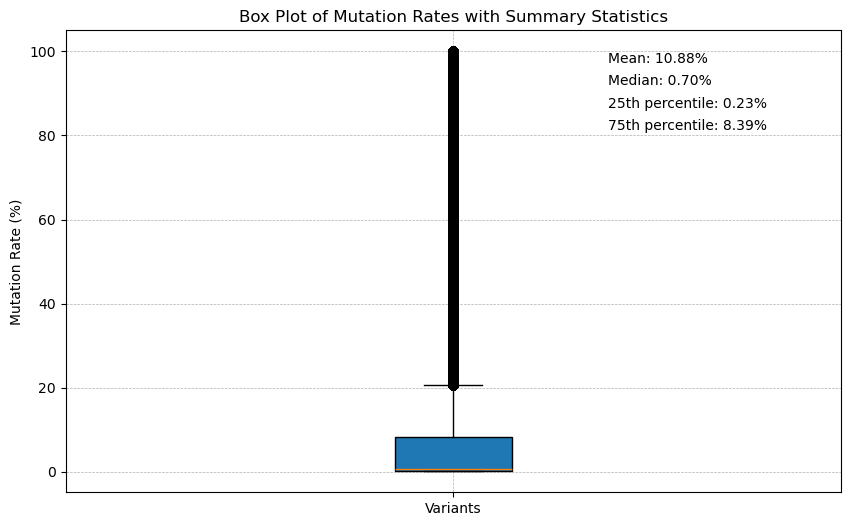

In [25]:
# Assuming mutation_rates is already defined and contains the mutation rate percentages
# Create a box plot for the mutation rates
plt.figure(figsize=(10, 6))
plt.boxplot(mutation_rates, vert=True, patch_artist=True)
plt.title('Box Plot of Mutation Rates with Summary Statistics')
plt.ylabel('Mutation Rate (%)')
plt.xticks([1], ['Variants'])

# Calculate summary statistics for display
mean_rate = np.mean(mutation_rates)
median_rate = np.median(mutation_rates)
percentile_25 = np.percentile(mutation_rates, 25)
percentile_75 = np.percentile(mutation_rates, 75)

# Get the current ylim of the plot to place text appropriately
current_ylim = plt.gca().get_ylim()
upper_ylim = current_ylim[1] - (current_ylim[1] * 0.05)  # A little below the upper y-limit

# Place text in the upper right corner of the plot
plt.text(1.2, upper_ylim, f'Mean: {mean_rate:.2f}%', verticalalignment='top')
plt.text(1.2, upper_ylim - (current_ylim[1] * 0.05), f'Median: {median_rate:.2f}%', verticalalignment='top')
plt.text(1.2, upper_ylim - (current_ylim[1] * 0.10), f'25th percentile: {percentile_25:.2f}%', verticalalignment='top')
plt.text(1.2, upper_ylim - (current_ylim[1] * 0.15), f'75th percentile: {percentile_75:.2f}%', verticalalignment='top')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Select variants with mutation_rates
flt = mutation_rates > 40

gf_new = gf.compress(flt, axis=0) # This is the filtering step
gn_new = gf_new.to_n_alt()

In [40]:
gn_new.shape

(33732, 645)

# 7 - Dimensionality Reduction - PCA

Before we can apply techniques like Principal Component Analysis (PCA) or other machine learning methods, we need to convert the raw genetic data into a numerical matrix.

To express genotype call data as numbers, we can perform an operation known as **allele count**. When we perform an allele count to create a numeric matrix from genetic data, we're translating genotypes into a format suitable for mathematical and statistical analyses. Each position in the genome where a variant occurs can have multiple forms, or alleles. The standard reference genome provides the reference allele, while any variation from this is considered an alternative allele.

In this numeric matrix:

A count of 0 indicates that the sample contains two reference alleles at a particular genomic position (homozygous reference).
A count of 1 indicates that the sample contains one reference allele and one alternative allele at that position (heterozygous).
A count of 2 indicates that the sample contains two alternative alleles (homozygous alternative).

This system allows us to quantify the genetic variation at each locus numerically. However, in some cases, the genotype information may be missing for a particular variant in a sample. To account for this in the numeric matrix, we use a special value. A count of -1 is used to represent missing data, signifying that it's unknown whether the sample has reference or alternative alleles at that position.

By encoding the genotypes in this manner, we transform the categorical data of genotypes into a numerical format that can be used for dimensionality reduction methods like PCA. This transformation is crucial because it allows us to apply algebraic operations and leverage statistical tools that require numerical input, facilitating the identification of patterns and relationships in the genetic data.

In [41]:
# Transpose matrix
matrix = gn_new.T
# PCA 
pca = decomposition.PCA(n_components=2)
pca.fit(matrix)

to_plot = pca.transform(matrix)

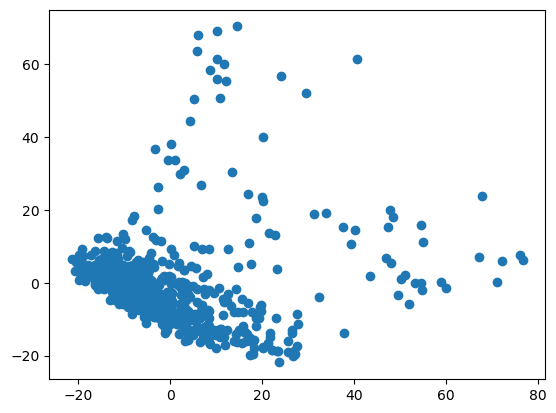

In [42]:
plt.scatter(x=to_plot[:, 0], y=to_plot[:, 1])

The PCA plot illustrates that the majority of data points cluster closely together when represented by the first two principal components. Notably, only a small subset of data points appears distantly projected from the main cluster. This pattern indicates that, within the scope of the genetic variation captured by these components, there may not be stark distinctions between the disease states encoded within the WES dataset. Such a distribution could suggest that the genetic differences related to these conditions are subtle or that the principal components selected may not be capturing the variance relevant to distinguish the disease state from healthy subjects.

# 4 - Future directions

To further enhance the analysis and move towards biomarker discovery, the following steps are recommended:

**Feature Selection**
Implement feature selection methods to identify the genomic variants most predictive of disease status. Techniques such as Random Forest, LASSO, or Elastic Net can be useful for this purpose.

**Integration with Other Data Types**
Consider integrating WES data with other omics data (e.g., transcriptomics, metabolomics) for a comprehensive multi-omic analysis that could be helpful to better differentiate the disease labels.
